# Project 11: Market Basket Analysis

**Type:** Association Rule Mining | **Level:** Intermediate

Discover product associations and buying patterns using Apriori algorithm.

**Model:** Apriori Algorithm

**Dataset:** [Kaggle Market Basket Analysis](https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis)

## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [2]:
# Load the dataset - using semicolon as separator
df = pd.read_csv('../data/market_basket/Assignment-1_Data.csv', 
                 sep=';',
                 encoding='utf-8',
                 on_bad_lines='skip')

# Rename columns for easier use
df = df.rename(columns={
    'BillNo': 'Transaction',
    'Itemname': 'Item',
    'Quantity': 'Quantity',
    'Date': 'Date',
    'Price': 'Price',
    'CustomerID': 'CustomerID',
    'Country': 'Country'
})

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (522064, 7)

Column names:
['Transaction', 'Item', 'Quantity', 'Date', 'Price', 'CustomerID', 'Country']

First few rows:


,Transaction,Item,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
5,536365,SET 7 BABUSHKA NESTING BOXES,2,01.12.2010 08:26,"7,65",17850.0,United Kingdom
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,01.12.2010 08:26,"4,25",17850.0,United Kingdom
7,536366,HAND WARMER UNION JACK,6,01.12.2010 08:28,"1,85",17850.0,United Kingdom
8,536366,HAND WARMER RED POLKA DOT,6,01.12.2010 08:28,"1,85",17850.0,United Kingdom
9,536367,ASSORTED COLOUR BIRD ORNAMENT,32,01.12.2010 08:34,"1,69",13047.0,United Kingdom


## 3. Exploratory Data Analysis

Dataset Info:
Rows: 522064, Columns: 7

Data types:
Transaction     object
Item            object
Quantity         int64
Date            object
Price           object
CustomerID     float64
Country         object
dtype: object

Missing values:
Transaction         0
Item             1455
Quantity            0
Date                0
Price               0
CustomerID     134041
Country             0
dtype: int64

Unique transactions: 21665

Unique items: 4185


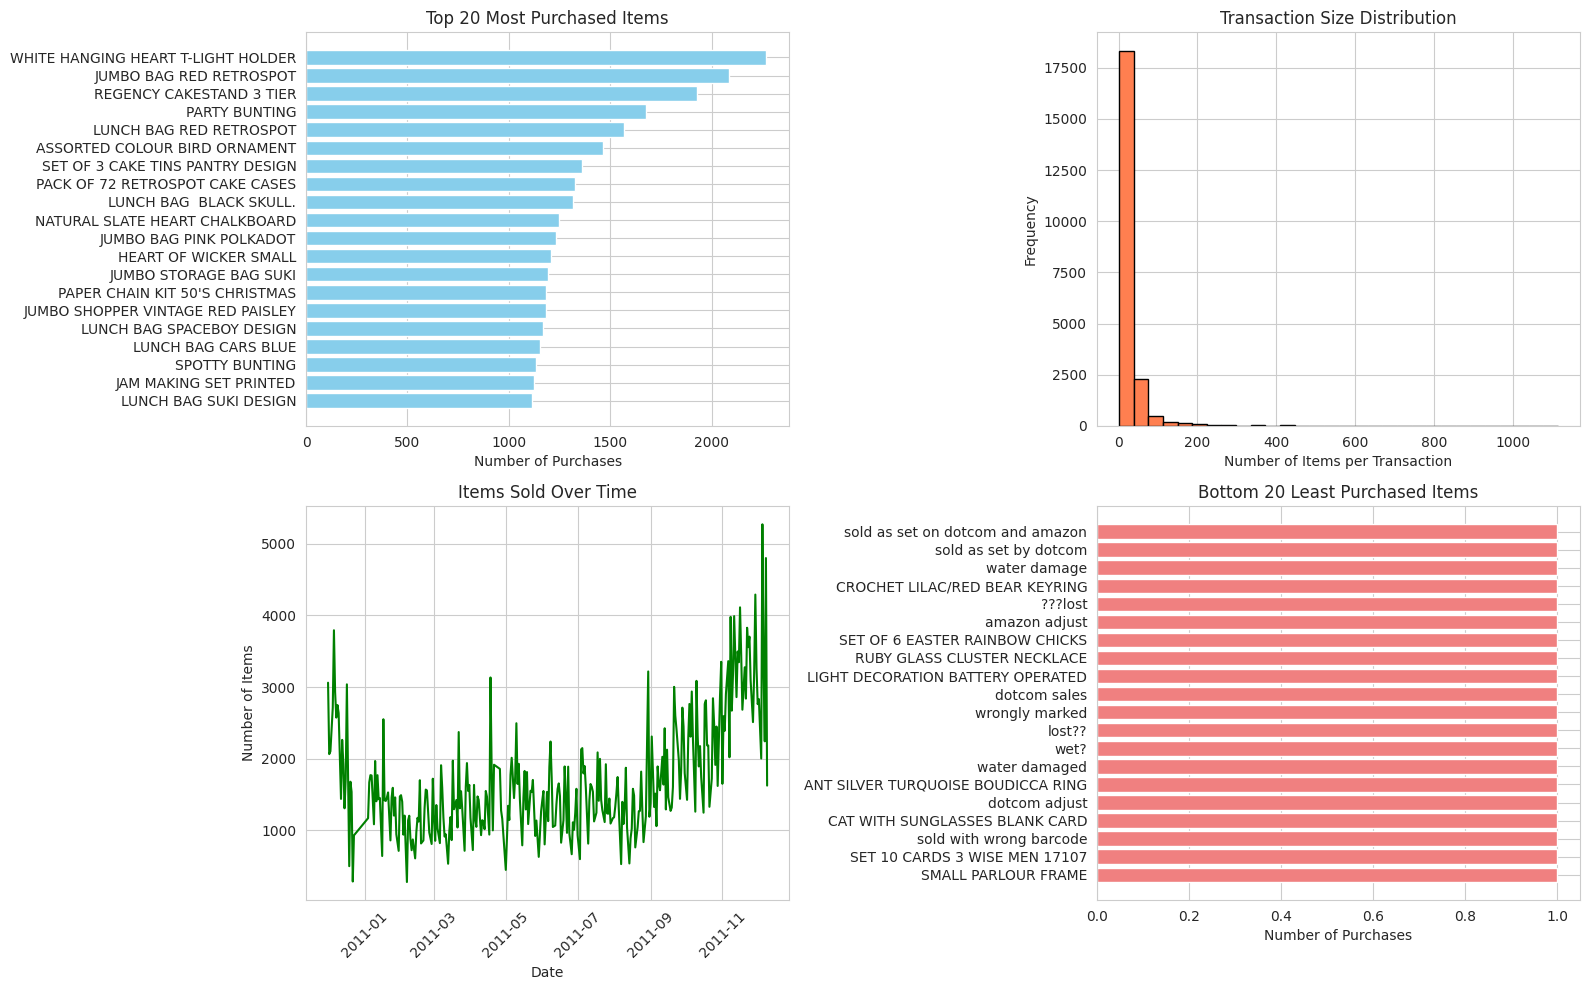


Average items per transaction: 24.10
Median items per transaction: 13
Max items per transaction: 1114


In [3]:
# Basic info
print("Dataset Info:")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nUnique transactions: {df['Transaction'].nunique()}")
print(f"\nUnique items: {df['Item'].nunique()}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top 20 most purchased items
top_items = df['Item'].value_counts().head(20)
axes[0, 0].barh(range(len(top_items)), top_items.values, color='skyblue')
axes[0, 0].set_yticks(range(len(top_items)))
axes[0, 0].set_yticklabels(top_items.index)
axes[0, 0].set_title('Top 20 Most Purchased Items')
axes[0, 0].set_xlabel('Number of Purchases')
axes[0, 0].invert_yaxis()

# Transaction size distribution
transaction_sizes = df.groupby('Transaction').size()
axes[0, 1].hist(transaction_sizes, bins=30, edgecolor='black', color='coral')
axes[0, 1].set_title('Transaction Size Distribution')
axes[0, 1].set_xlabel('Number of Items per Transaction')
axes[0, 1].set_ylabel('Frequency')

# Items per period (if date column exists)
if 'Date' in df.columns or 'date' in df.columns:
    date_col = 'Date' if 'Date' in df.columns else 'date'
    df[date_col] = pd.to_datetime(df[date_col], format='%d.%m.%Y %H:%M', errors='coerce')
    items_per_date = df.groupby(df[date_col].dt.date).size()
    axes[1, 0].plot(items_per_date.index, items_per_date.values, color='green')
    axes[1, 0].set_title('Items Sold Over Time')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Number of Items')
    axes[1, 0].tick_params(axis='x', rotation=45)
else:
    axes[1, 0].text(0.5, 0.5, 'No date column available', 
                     ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Items Sold Over Time (N/A)')

# Bottom 20 least purchased items
bottom_items = df['Item'].value_counts().tail(20)
axes[1, 1].barh(range(len(bottom_items)), bottom_items.values, color='lightcoral')
axes[1, 1].set_yticks(range(len(bottom_items)))
axes[1, 1].set_yticklabels(bottom_items.index)
axes[1, 1].set_title('Bottom 20 Least Purchased Items')
axes[1, 1].set_xlabel('Number of Purchases')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nAverage items per transaction: {transaction_sizes.mean():.2f}")
print(f"Median items per transaction: {transaction_sizes.median():.0f}")
print(f"Max items per transaction: {transaction_sizes.max()}")

## 4. Data Preprocessing

In [4]:
# Clean data first - remove rows with missing items or cancelled orders
df_clean = df.dropna(subset=['Item', 'Transaction'])
df_clean = df_clean[df_clean['Quantity'] > 0]  # Remove cancelled orders

# Transform data into transaction format (list of lists)
# Group items by transaction
transactions = df_clean.groupby('Transaction')['Item'].apply(list).values.tolist()

print(f"Total transactions: {len(transactions)}")
print(f"\nSample transactions:")
for i in range(min(5, len(transactions))):
    print(f"Transaction {i+1}: {transactions[i][:5]}{'...' if len(transactions[i]) > 5 else ''}")

# Encode transactions into one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"\nEncoded dataframe shape: {df_encoded.shape}")
print(f"Number of unique items: {len(te.columns_)}")
print(f"\nFirst few rows of encoded data:")
df_encoded.head()

Total transactions: 19737

Sample transactions:
Transaction 1: ['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN', 'CREAM CUPID HEARTS COAT HANGER', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART.']...
Transaction 2: ['HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT']
Transaction 3: ['ASSORTED COLOUR BIRD ORNAMENT', "POPPY'S PLAYHOUSE BEDROOM", "POPPY'S PLAYHOUSE KITCHEN", 'FELTCRAFT PRINCESS CHARLOTTE DOLL', 'IVORY KNITTED MUG COSY']...
Transaction 4: ['JAM MAKING SET WITH JARS', 'RED COAT RACK PARIS FASHION', 'YELLOW COAT RACK PARIS FASHION', 'BLUE COAT RACK PARIS FASHION']
Transaction 5: ['BATH BUILDING BLOCK WORD']

Encoded dataframe shape: (19737, 4056)
Number of unique items: 4056

First few rows of encoded data:


,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 5. Apriori Algorithm

Running Apriori algorithm...
This may take a few minutes for large datasets...

Apriori algorithm completed!
Found 1896 frequent itemsets

Top 10 frequent itemsets:
      support                              itemsets
772  0.111567  (WHITE HANGING HEART T-LIGHT HOLDER)
342  0.104575             (JUMBO BAG RED RETROSPOT)
552  0.096469            (REGENCY CAKESTAND 3 TIER)
460  0.083903                       (PARTY BUNTING)
382  0.078077             (LUNCH BAG RED RETROSPOT)
49   0.072503       (ASSORTED COLOUR BIRD ORNAMENT)
620  0.068197    (SET OF 3 CAKE TINS PANTRY DESIGN)
439  0.064802     (PACK OF 72 RETROSPOT CAKE CASES)
374  0.063839             (LUNCH BAG  BLACK SKULL.)
413  0.062421      (NATURAL SLATE HEART CHALKBOARD)


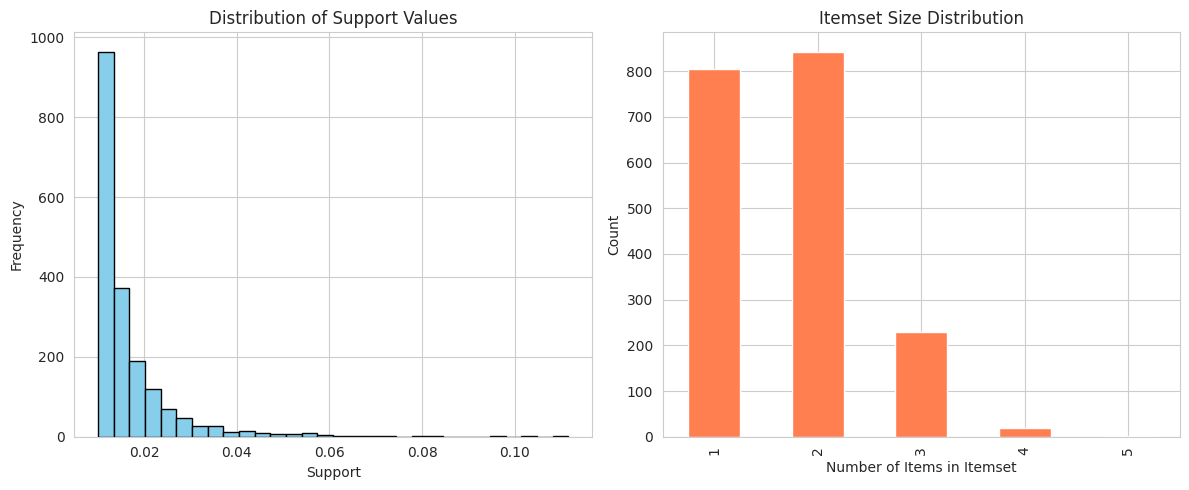


Itemset statistics:
Single items: 805
Item pairs: 843
Item triplets: 229
Larger itemsets: 19


In [5]:
# Apply Apriori algorithm to find frequent itemsets
print("Running Apriori algorithm...")
print("This may take a few minutes for large datasets...")

# Set minimum support threshold (items appearing in at least 1% of transactions)
min_support = 0.01

frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

print(f"\nApriori algorithm completed!")
print(f"Found {len(frequent_itemsets)} frequent itemsets")
print(f"\nTop 10 frequent itemsets:")
frequent_itemsets_sorted = frequent_itemsets.sort_values('support', ascending=False).head(10)
print(frequent_itemsets_sorted)

# Visualize support distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(frequent_itemsets['support'], bins=30, edgecolor='black', color='skyblue')
plt.title('Distribution of Support Values')
plt.xlabel('Support')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
itemset_lengths = frequent_itemsets['itemsets'].apply(lambda x: len(x))
itemset_lengths.value_counts().sort_index().plot(kind='bar', color='coral')
plt.title('Itemset Size Distribution')
plt.xlabel('Number of Items in Itemset')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print(f"\nItemset statistics:")
print(f"Single items: {(itemset_lengths == 1).sum()}")
print(f"Item pairs: {(itemset_lengths == 2).sum()}")
print(f"Item triplets: {(itemset_lengths == 3).sum()}")
print(f"Larger itemsets: {(itemset_lengths > 3).sum()}")

## 6. Association Rules

Generating association rules...

Generated 1812 association rules

Top 10 rules by lift:
                                      antecedents  \
1049                          (HERB MARKER THYME)   
1048  (HERB MARKER PARSLEY, HERB MARKER ROSEMARY)   
1046     (HERB MARKER THYME, HERB MARKER PARSLEY)   
1051                       (HERB MARKER ROSEMARY)   
294                           (HERB MARKER THYME)   
295                        (HERB MARKER ROSEMARY)   
1047    (HERB MARKER THYME, HERB MARKER ROSEMARY)   
1050                        (HERB MARKER PARSLEY)   
293                         (HERB MARKER PARSLEY)   
292                           (HERB MARKER THYME)   

                                      consequents   support  confidence  \
1049  (HERB MARKER PARSLEY, HERB MARKER ROSEMARY)  0.010133    0.858369   
1048                          (HERB MARKER THYME)  0.010133    0.952381   
1046                       (HERB MARKER ROSEMARY)  0.010133    0.952381   
1051     (HERB MARKER THYME

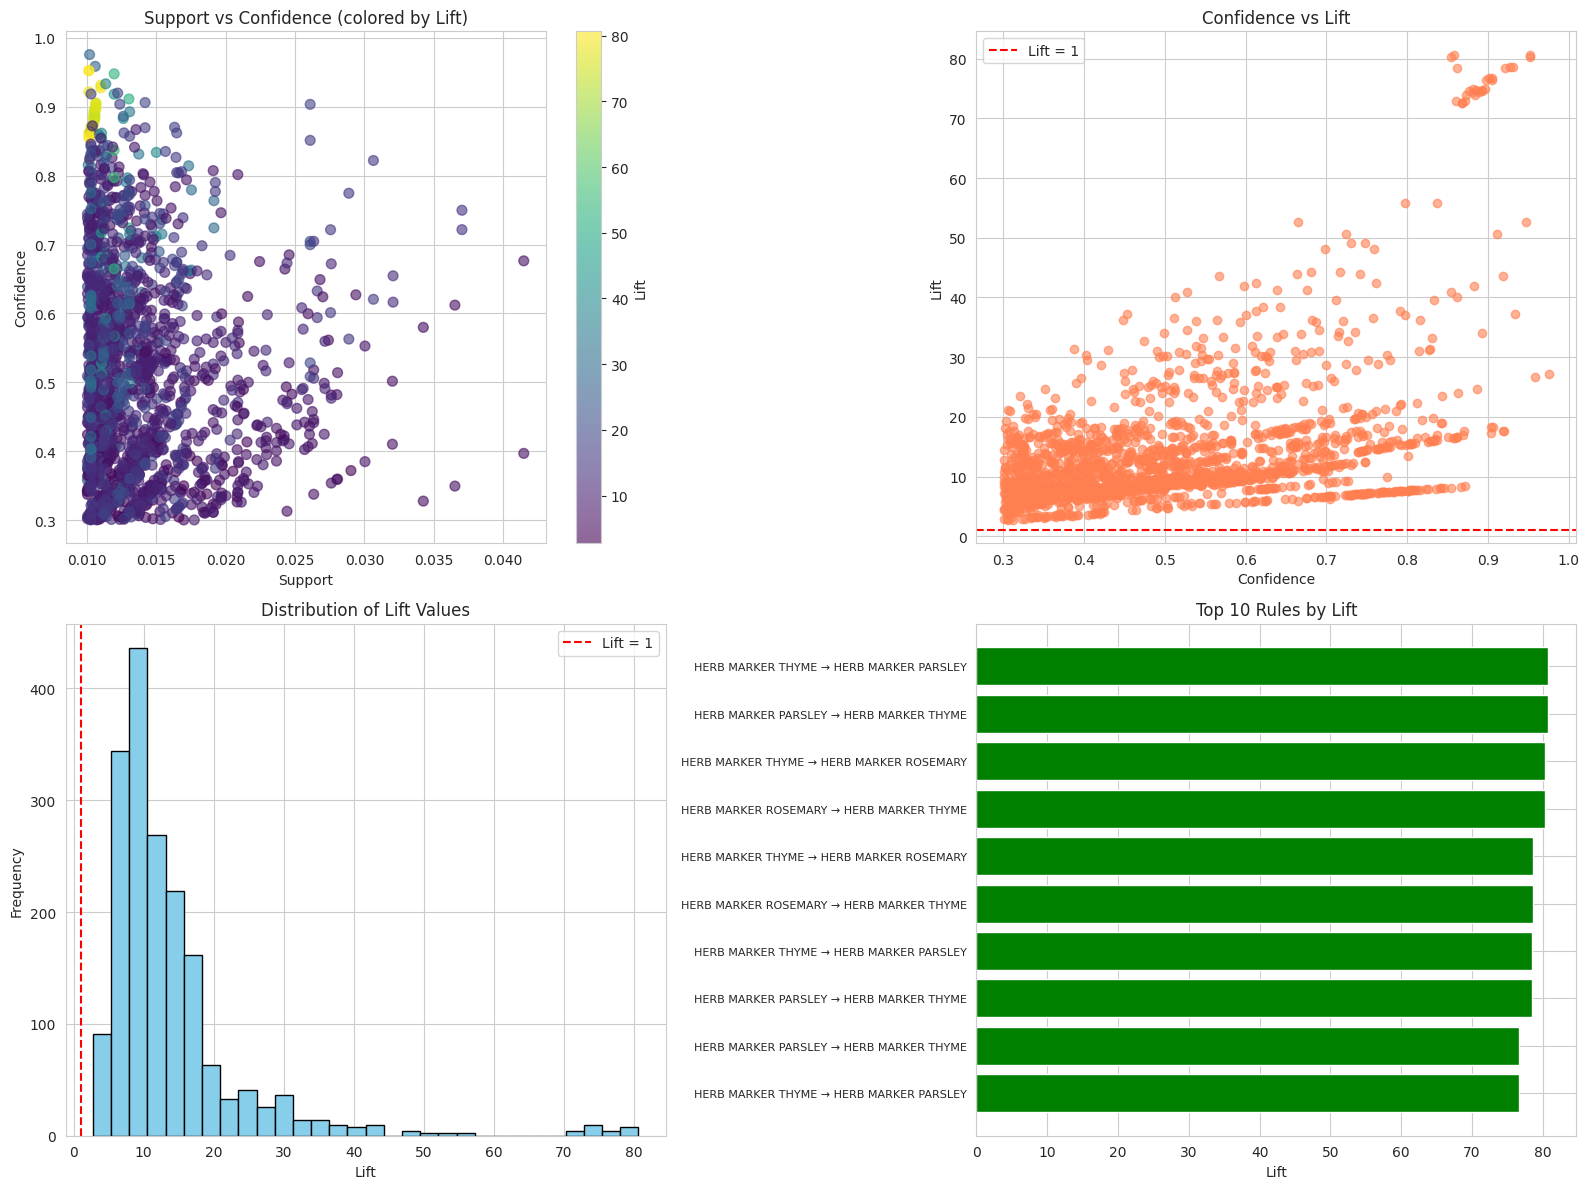


Rule statistics:
Average support: 0.0137
Average confidence: 0.5167
Average lift: 13.8758
Rules with lift > 1: 1812 (100.0%)


In [6]:
# Generate association rules from frequent itemsets
print("Generating association rules...")

# Generate rules with minimum confidence threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

# Sort by lift (most interesting rules first)
rules_sorted = rules.sort_values('lift', ascending=False)

print(f"\nGenerated {len(rules)} association rules")
print(f"\nTop 10 rules by lift:")
print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Support vs Confidence
scatter = axes[0, 0].scatter(rules['support'], rules['confidence'], 
                              c=rules['lift'], cmap='viridis', alpha=0.6, s=50)
axes[0, 0].set_xlabel('Support')
axes[0, 0].set_ylabel('Confidence')
axes[0, 0].set_title('Support vs Confidence (colored by Lift)')
plt.colorbar(scatter, ax=axes[0, 0], label='Lift')

# Confidence vs Lift
axes[0, 1].scatter(rules['confidence'], rules['lift'], alpha=0.6, color='coral')
axes[0, 1].set_xlabel('Confidence')
axes[0, 1].set_ylabel('Lift')
axes[0, 1].set_title('Confidence vs Lift')
axes[0, 1].axhline(y=1, color='r', linestyle='--', label='Lift = 1')
axes[0, 1].legend()

# Lift distribution
axes[1, 0].hist(rules['lift'], bins=30, edgecolor='black', color='skyblue')
axes[1, 0].set_xlabel('Lift')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Lift Values')
axes[1, 0].axvline(x=1, color='r', linestyle='--', label='Lift = 1')
axes[1, 0].legend()

# Top 10 rules by lift (bar chart)
top_rules = rules_sorted.head(10).copy()
top_rules['rule'] = top_rules.apply(
    lambda x: f"{list(x['antecedents'])[0][:20]} → {list(x['consequents'])[0][:20]}", axis=1
)
axes[1, 1].barh(range(len(top_rules)), top_rules['lift'].values, color='green')
axes[1, 1].set_yticks(range(len(top_rules)))
axes[1, 1].set_yticklabels(top_rules['rule'].values, fontsize=8)
axes[1, 1].set_xlabel('Lift')
axes[1, 1].set_title('Top 10 Rules by Lift')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nRule statistics:")
print(f"Average support: {rules['support'].mean():.4f}")
print(f"Average confidence: {rules['confidence'].mean():.4f}")
print(f"Average lift: {rules['lift'].mean():.4f}")
print(f"Rules with lift > 1: {(rules['lift'] > 1).sum()} ({(rules['lift'] > 1).sum() / len(rules) * 100:.1f}%)")

## 7. Save Results

In [7]:
# Save frequent itemsets and association rules
import joblib

# Save frequent itemsets
frequent_itemsets.to_csv('../models/market_basket_frequent_itemsets.csv', index=False)
print("Frequent itemsets saved to: ../models/market_basket_frequent_itemsets.csv")

# Save association rules
rules.to_csv('../models/market_basket_association_rules.csv', index=False)
print("Association rules saved to: ../models/market_basket_association_rules.csv")

# Save metadata
metadata = {
    'min_support': min_support,
    'min_confidence': 0.3,
    'total_transactions': len(transactions),
    'total_items': len(te.columns_),
    'total_frequent_itemsets': len(frequent_itemsets),
    'total_rules': len(rules)
}
joblib.dump(metadata, '../models/market_basket_metadata.pkl')
print("Metadata saved!")

# Print final summary
print("\n" + "="*50)
print("MARKET BASKET ANALYSIS SUMMARY")
print("="*50)
print(f"Total transactions analyzed: {len(transactions)}")
print(f"Unique items: {len(te.columns_)}")
print(f"Frequent itemsets found: {len(frequent_itemsets)}")
print(f"Association rules generated: {len(rules)}")
print(f"\nTop 3 strongest associations (by lift):")
for idx, row in rules_sorted.head(3).iterrows():
    ant = list(row['antecedents'])[0]
    cons = list(row['consequents'])[0]
    print(f"  {ant} → {cons}")
    print(f"    Support: {row['support']:.4f}, Confidence: {row['confidence']:.4f}, Lift: {row['lift']:.4f}")
print("\nUse these insights for product placement, promotions,")
print("and recommendation systems!")

Frequent itemsets saved to: ../models/market_basket_frequent_itemsets.csv
Association rules saved to: ../models/market_basket_association_rules.csv
Metadata saved!

MARKET BASKET ANALYSIS SUMMARY
Total transactions analyzed: 19737
Unique items: 4056
Frequent itemsets found: 1896
Association rules generated: 1812

Top 3 strongest associations (by lift):
  HERB MARKER THYME → HERB MARKER PARSLEY
    Support: 0.0101, Confidence: 0.8584, Lift: 80.6744
  HERB MARKER PARSLEY → HERB MARKER THYME
    Support: 0.0101, Confidence: 0.9524, Lift: 80.6744
  HERB MARKER THYME → HERB MARKER ROSEMARY
    Support: 0.0101, Confidence: 0.9524, Lift: 80.3297

Use these insights for product placement, promotions,
and recommendation systems!
